# Import

In [1]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR, ReduceLROnPlateau
import sys, os

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname("src"))))

from src.Mydataloader import LoadDataset
from src.Mymodel import MyResNet_CIFAR
from src.Mytraining import DoTraining
from src.Earlystopper import EarlyStopper
from src.LogViewer import LogViewer

# Setup

In [2]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Dataset parameters"""
BATCH = 128
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True
SPLIT_RATIO = 0.95

"""optimizer parameters"""
# OPTIMIZER = "Adam"
# OPTIMIZER = "Adam_decay"
OPTIMIZER = "SGD"
# OPTIMIZER = "SGD_nasterov"
# OPTIMIZER = "AdamW"
# OPTIMIZER = "AdamW_amsgrad"
# OPTIMIZER = "NAdam"

"""Learning rate scheduler parameters"""
NUM_EPOCHS = 200

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = 50

file_name = f"MyResNet32_{BATCH}_{OPTIMIZER}"

In [3]:
file_name

'MyResNet32_128_SGD'

# Loading the dataset

## Define Dateloader

In [4]:
tmp = LoadDataset(root="../../data", seceted_dataset=DATASET, split_ratio=SPLIT_RATIO)
train_data, valid_data, test_data, COUNT_OF_CLASSES = tmp.Unpack()

-----------------------------------------------------------------------
Dataset :  CIFAR10
- Length of Train Set :  47500
- Length of Valid Set :  2500
- Length of Test Set :  10000
- Count of Classes :  10
-----------------------------------------------------------------------


In [5]:
train_dataloader, valid_dataloader, test_dataloader = tmp.get_dataloader(
    batch_size=BATCH, shuffle=SHUFFLE, num_workers=NUMOFWORKERS, pin_memory=PIN_MEMORY
)


train.transforms = Compose(
      Compose(
        ToImage()
        ToDtype(scale=True)
  )
      Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[1, 1, 1], inplace=True)
      AutoAugment(interpolation=InterpolationMode.NEAREST, policy=AutoAugmentPolicy.CIFAR10)
      RandomCrop(size=(32, 32), padding=[4, 4, 4, 4], pad_if_needed=False, fill=0, padding_mode=constant)
      RandomHorizontalFlip(p=0.5)
) 128
valid.transforms = (Compose(
      ToImage()
      ToDtype(scale=True)
),) 128
test.transforms = Compose(
      ToImage()
      ToDtype(scale=True)
) 128


# Define ResNet

## Model Confirm

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
model = MyResNet_CIFAR(num_classes=COUNT_OF_CLASSES, num_layer_factor=5).to(device)

# Define Training

## (1) Define Criterion

In [8]:
criterion = nn.CrossEntropyLoss()

## (2) Define Optimazer

In [9]:
if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
elif OPTIMIZER == "Adam_decay":
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001
    )
elif OPTIMIZER == "SGD_nasterov":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4, nesterov=True
    )
elif OPTIMIZER == "AdamW":
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "AdamW_amsgrad":
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4, amsgrad=True)
elif OPTIMIZER == "NAdam":
    optimizer = torch.optim.NAdam(model.parameters(), weight_decay=1e-4)

## (3) Define Early Stopping

In [10]:
earlystopper = EarlyStopper(patience=EARLYSTOPPINGPATIENCE, model=model, file_name=file_name)

## (4) Define Learning Rate schedualer

In [11]:
# scheduler = ExponentialLR(optimizer, gamma=0.95)
# scheduler = MultiStepLR(optimizer, milestones=[82, 123], gamma=0.1)
scheduler = ReduceLROnPlateau(optimizer=optimizer, patience=10, factor=0.1, cooldown=40)
"""
=======================================================
if batch = 256
=======================================================
non-split [single epoch = 196 iter] : milestones = [164, 246]
- 1 ~ 164 epochs == 1 ~ 32k iter >> lr = 0.1
- 165~246 epochs == 32k ~ 48k iter >> lr = 0.01
- 247~328(?) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
split to 45k/5k [single epoch = 176 iter]: milestones = [182, 273]
- 1~182 epochs == 1 ~ 32k iter >> lr = 0.1
- 182~273 epochs == 32k ~ 48k iter >> lr = 0.01
- 273~364(?) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
if batch = 128
=======================================================
non-split [signle epoch = 391 iter]: milestones = [82, 123]
- 1 ~ 82 epochs == 1 ~ 32k iter >> lr = 0.1
- 83~123 epochs == 32k ~ 48k iter >> lr = 0.01
- 124~(164) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
split to 45k/5k [signle epoch = 352 iter]: milestones = [91, 137]
- 1~91 epochs == 1 ~ 32k iter >> lr = 0.1
- 92~137 epochs == 32k ~ 48k iter >> lr = 0.01
- 138~(183) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
"""

'\n=======================================================\nif batch = 256\n=======================================================\nnon-split [single epoch = 196 iter] : milestones = [164, 246]\n- 1 ~ 164 epochs == 1 ~ 32k iter >> lr = 0.1\n- 165~246 epochs == 32k ~ 48k iter >> lr = 0.01\n- 247~328(?) epochs == 48k ~ 64k iter >> lr = 0.001\n=======================================================\nsplit to 45k/5k [single epoch = 176 iter]: milestones = [182, 273]\n- 1~182 epochs == 1 ~ 32k iter >> lr = 0.1\n- 182~273 epochs == 32k ~ 48k iter >> lr = 0.01\n- 273~364(?) epochs == 48k ~ 64k iter >> lr = 0.001\n=======================================================\nif batch = 128\n=======================================================\nnon-split [signle epoch = 391 iter]: milestones = [82, 123]\n- 1 ~ 82 epochs == 1 ~ 32k iter >> lr = 0.1\n- 83~123 epochs == 32k ~ 48k iter >> lr = 0.01\n- 124~(164) epochs == 48k ~ 64k iter >> lr = 0.001\n=================================================

## (5) Define AMP scaler

In [12]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

## Load before process

In [13]:
if os.path.exists(file_name + ".pth.tar"):
    # Read checkpoint as desired, e.g.,
    checkpoint = torch.load(
        file_name + ".pth.tar",
        map_location=lambda storage, loc: storage.cuda(device),
    )
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scaler.load_state_dict(checkpoint["scaler"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    earlystopper.load_state_dict(checkpoint["earlystopper"])
    logs = checkpoint["logs"]

    print("Suceessfully loaded the All setting and Log file.")
    print(file_name)
    print(f"Current epoch is {len(logs['train_loss'])}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
else:
    # Create a dictionary to store the variables
    train_loss = []
    train_acc = []
    eval_loss = []
    valid_acc = []
    test_loss = []
    test_acc = []
    lr_log = []
    logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": eval_loss,
        "valid_acc": valid_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "lr_log": lr_log,
    }
    print("File does not exist. Created a new log.")

File does not exist. Created a new log.


In [14]:
optimizer.param_groups[0]["lr"]

0.1

In [15]:
earlystopper.early_stop_counter

0

# [Training Loop]

In [16]:
Training = DoTraining(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler=scheduler,
    earlystopper=earlystopper,
    device=device,
    logs=logs,
    file_path=file_name,
)
pre_epochs = len(Training.logs["train_loss"])


for epoch in range(NUM_EPOCHS):
    now = epoch + 1 + pre_epochs
    print(f"[Epoch {epoch+1+pre_epochs}/{NUM_EPOCHS}] :")

    if DATASET == "ImageNet2012":
        eval_loss = Training.SingleEpoch(train_dataloader, valid_dataloader)
    else:
        eval_loss = Training.SingleEpoch(
            train_dataloader, valid_dataloader, test_dataloader
        )

    Training.Save()

    
    
    if earlystopper.check(eval_loss) == True:
        break

    print("-" * 50)

[Epoch 1/200] :


1 Train: 100%|███████| 372/372 [00:46<00:00,  8.07it/s]

Train Loss: 2.4304 | Train Acc: 10.96%


Valid Loss: 2.2978 | Valid Acc: 10.64%
Test  Loss: 2.2966 | Test Acc: 10.55%
updated best eval loss : 2.2978232383728026
--------------------------------------------------
[Epoch 2/200] :


2 Train: 100%|███████| 372/372 [00:43<00:00,  8.47it/s]


Train Loss: 2.1591 | Train Acc: 17.17%
Valid Loss: 2.1131 | Valid Acc: 17.60%
Test  Loss: 2.0202 | Test Acc: 19.29%
updated best eval loss : 2.113135814666748
--------------------------------------------------
[Epoch 3/200] :


3 Train: 100%|███████| 372/372 [00:44<00:00,  8.34it/s]


Train Loss: 1.9527 | Train Acc: 26.52%
Valid Loss: 2.0780 | Valid Acc: 25.16%
Test  Loss: 2.0032 | Test Acc: 26.18%
updated best eval loss : 2.0779769241809847
--------------------------------------------------
[Epoch 4/200] :


4 Train: 100%|███████| 372/372 [00:43<00:00,  8.59it/s]


Train Loss: 1.7488 | Train Acc: 35.54%
Valid Loss: 1.8120 | Valid Acc: 34.24%
Test  Loss: 1.6144 | Test Acc: 40.99%
updated best eval loss : 1.8119832098484039
--------------------------------------------------
[Epoch 5/200] :


5 Train: 100%|███████| 372/372 [00:44<00:00,  8.38it/s]


Train Loss: 1.5424 | Train Acc: 43.84%
Valid Loss: 1.5383 | Valid Acc: 46.04%
Test  Loss: 1.2003 | Test Acc: 57.12%
updated best eval loss : 1.5382500410079956
--------------------------------------------------
[Epoch 6/200] :


6 Train: 100%|███████| 372/372 [00:43<00:00,  8.53it/s]


Train Loss: 1.3690 | Train Acc: 50.71%
Valid Loss: 1.3517 | Valid Acc: 51.56%
Test  Loss: 1.1476 | Test Acc: 58.82%
updated best eval loss : 1.3517017126083375
--------------------------------------------------
[Epoch 7/200] :


7 Train: 100%|███████| 372/372 [00:43<00:00,  8.55it/s]


Train Loss: 1.2245 | Train Acc: 56.70%
Valid Loss: 1.3060 | Valid Acc: 54.04%
Test  Loss: 1.1024 | Test Acc: 63.10%
updated best eval loss : 1.306043803691864
--------------------------------------------------
[Epoch 8/200] :


8 Train: 100%|███████| 372/372 [00:43<00:00,  8.55it/s]


Train Loss: 1.1250 | Train Acc: 60.33%
Valid Loss: 1.1294 | Valid Acc: 59.40%
Test  Loss: 0.9145 | Test Acc: 68.69%
updated best eval loss : 1.1293584287166596
--------------------------------------------------
[Epoch 9/200] :


9 Train: 100%|███████| 372/372 [00:44<00:00,  8.37it/s]


Train Loss: 1.0579 | Train Acc: 62.94%
Valid Loss: 1.1073 | Valid Acc: 61.92%
Test  Loss: 0.8243 | Test Acc: 71.44%
updated best eval loss : 1.1073096334934234
--------------------------------------------------
[Epoch 10/200] :


10 Train: 100%|██████| 372/372 [00:42<00:00,  8.66it/s]


Train Loss: 1.0204 | Train Acc: 64.11%
Valid Loss: 1.0332 | Valid Acc: 63.76%
Test  Loss: 0.7336 | Test Acc: 74.51%
updated best eval loss : 1.03320714533329
--------------------------------------------------
[Epoch 11/200] :


11 Train: 100%|██████| 372/372 [00:43<00:00,  8.65it/s]


Train Loss: 0.9692 | Train Acc: 66.11%
Valid Loss: 1.1835 | Valid Acc: 60.92%
Test  Loss: 1.0807 | Test Acc: 65.21%
--------------------------------------------------
[Epoch 12/200] :


12 Train: 100%|██████| 372/372 [00:44<00:00,  8.33it/s]


Train Loss: 0.9312 | Train Acc: 67.45%
Valid Loss: 1.0265 | Valid Acc: 64.00%
Test  Loss: 0.7612 | Test Acc: 74.40%
updated best eval loss : 1.0264923572540283
--------------------------------------------------
[Epoch 13/200] :


13 Train: 100%|██████| 372/372 [00:44<00:00,  8.41it/s]


Train Loss: 0.9097 | Train Acc: 68.35%
Valid Loss: 1.0807 | Valid Acc: 64.16%
Test  Loss: 0.7814 | Test Acc: 74.01%
--------------------------------------------------
[Epoch 14/200] :


14 Train: 100%|██████| 372/372 [00:43<00:00,  8.53it/s]


Train Loss: 0.9018 | Train Acc: 68.34%
Valid Loss: 0.9514 | Valid Acc: 66.32%
Test  Loss: 0.6514 | Test Acc: 76.76%
updated best eval loss : 0.9514444082975387
--------------------------------------------------
[Epoch 15/200] :


15 Train: 100%|██████| 372/372 [00:42<00:00,  8.69it/s]


Train Loss: 0.8593 | Train Acc: 69.87%
Valid Loss: 0.9752 | Valid Acc: 66.60%
Test  Loss: 0.7146 | Test Acc: 76.30%
--------------------------------------------------
[Epoch 16/200] :


16 Train: 100%|██████| 372/372 [00:43<00:00,  8.62it/s]


Train Loss: 0.8485 | Train Acc: 70.31%
Valid Loss: 0.8904 | Valid Acc: 69.12%
Test  Loss: 0.6216 | Test Acc: 78.77%
updated best eval loss : 0.8903704732656479
--------------------------------------------------
[Epoch 17/200] :


17 Train: 100%|██████| 372/372 [00:43<00:00,  8.58it/s]


Train Loss: 0.8271 | Train Acc: 71.03%
Valid Loss: 0.9228 | Valid Acc: 68.56%
Test  Loss: 0.6569 | Test Acc: 77.96%
--------------------------------------------------
[Epoch 18/200] :


18 Train: 100%|██████| 372/372 [00:43<00:00,  8.65it/s]


Train Loss: 0.8193 | Train Acc: 71.59%
Valid Loss: 0.9301 | Valid Acc: 68.48%
Test  Loss: 0.6272 | Test Acc: 78.42%
--------------------------------------------------
[Epoch 19/200] :


19 Train: 100%|██████| 372/372 [00:43<00:00,  8.63it/s]


Train Loss: 0.7954 | Train Acc: 72.01%
Valid Loss: 1.0479 | Valid Acc: 65.60%
Test  Loss: 0.6373 | Test Acc: 78.53%
--------------------------------------------------
[Epoch 20/200] :


20 Train: 100%|██████| 372/372 [00:42<00:00,  8.74it/s]


Train Loss: 0.7944 | Train Acc: 72.45%
Valid Loss: 0.8655 | Valid Acc: 70.80%
Test  Loss: 0.6882 | Test Acc: 76.59%
updated best eval loss : 0.8655394554138184
--------------------------------------------------
[Epoch 21/200] :


21 Train: 100%|██████| 372/372 [00:43<00:00,  8.53it/s]


Train Loss: 0.7709 | Train Acc: 72.89%
Valid Loss: 0.9635 | Valid Acc: 66.00%
Test  Loss: 0.6437 | Test Acc: 78.61%
--------------------------------------------------
[Epoch 22/200] :


22 Train: 100%|██████| 372/372 [00:44<00:00,  8.33it/s]


Train Loss: 0.7696 | Train Acc: 73.17%
Valid Loss: 0.8684 | Valid Acc: 70.68%
Test  Loss: 0.6161 | Test Acc: 79.02%
--------------------------------------------------
[Epoch 23/200] :


23 Train: 100%|██████| 372/372 [00:42<00:00,  8.67it/s]


Train Loss: 0.7557 | Train Acc: 73.70%
Valid Loss: 0.8007 | Valid Acc: 71.84%
Test  Loss: 0.5640 | Test Acc: 81.09%
updated best eval loss : 0.8007064491510392
--------------------------------------------------
[Epoch 24/200] :


24 Train: 100%|██████| 372/372 [00:43<00:00,  8.60it/s]


Train Loss: 0.7480 | Train Acc: 73.91%
Valid Loss: 0.8219 | Valid Acc: 72.12%
Test  Loss: 0.5119 | Test Acc: 82.73%
--------------------------------------------------
[Epoch 25/200] :


25 Train: 100%|██████| 372/372 [00:42<00:00,  8.74it/s]


Train Loss: 0.7393 | Train Acc: 74.16%
Valid Loss: 0.9292 | Valid Acc: 68.72%
Test  Loss: 0.7397 | Test Acc: 76.67%
--------------------------------------------------
[Epoch 26/200] :


26 Train: 100%|██████| 372/372 [00:43<00:00,  8.61it/s]


Train Loss: 0.7308 | Train Acc: 74.61%
Valid Loss: 0.7926 | Valid Acc: 72.68%
Test  Loss: 0.4826 | Test Acc: 83.34%
updated best eval loss : 0.7926132678985596
--------------------------------------------------
[Epoch 27/200] :


27 Train: 100%|██████| 372/372 [00:42<00:00,  8.71it/s]


Train Loss: 0.7155 | Train Acc: 75.08%
Valid Loss: 0.7511 | Valid Acc: 74.04%
Test  Loss: 0.5309 | Test Acc: 82.33%
updated best eval loss : 0.751126366853714
--------------------------------------------------
[Epoch 28/200] :


28 Train: 100%|██████| 372/372 [00:43<00:00,  8.59it/s]


Train Loss: 0.7227 | Train Acc: 74.81%
Valid Loss: 0.8390 | Valid Acc: 70.92%
Test  Loss: 0.6043 | Test Acc: 79.72%
--------------------------------------------------
[Epoch 29/200] :


29 Train: 100%|██████| 372/372 [00:43<00:00,  8.58it/s]


Train Loss: 0.7073 | Train Acc: 75.06%
Valid Loss: 0.7856 | Valid Acc: 72.16%
Test  Loss: 0.5165 | Test Acc: 82.22%
--------------------------------------------------
[Epoch 30/200] :


30 Train: 100%|██████| 372/372 [00:46<00:00,  7.98it/s]


Train Loss: 0.6987 | Train Acc: 75.63%
Valid Loss: 0.7650 | Valid Acc: 72.68%
Test  Loss: 0.5169 | Test Acc: 81.89%
--------------------------------------------------
[Epoch 31/200] :


31 Train: 100%|██████| 372/372 [00:45<00:00,  8.27it/s]


Train Loss: 0.6910 | Train Acc: 75.69%
Valid Loss: 0.8005 | Valid Acc: 72.76%
Test  Loss: 0.5811 | Test Acc: 80.64%
--------------------------------------------------
[Epoch 32/200] :


32 Train: 100%|██████| 372/372 [00:43<00:00,  8.52it/s]


Train Loss: 0.6918 | Train Acc: 75.77%
Valid Loss: 0.7736 | Valid Acc: 72.16%
Test  Loss: 0.5154 | Test Acc: 82.59%
--------------------------------------------------
[Epoch 33/200] :


33 Train: 100%|██████| 372/372 [00:45<00:00,  8.10it/s]


Train Loss: 0.6834 | Train Acc: 76.16%
Valid Loss: 0.8558 | Valid Acc: 70.68%
Test  Loss: 0.6002 | Test Acc: 80.14%
--------------------------------------------------
[Epoch 34/200] :


34 Train: 100%|██████| 372/372 [00:47<00:00,  7.75it/s]


Train Loss: 0.6845 | Train Acc: 76.23%
Valid Loss: 0.8473 | Valid Acc: 71.92%
Test  Loss: 0.5794 | Test Acc: 81.24%
--------------------------------------------------
[Epoch 35/200] :


35 Train: 100%|██████| 372/372 [00:46<00:00,  7.99it/s]


Train Loss: 0.6739 | Train Acc: 76.56%
Valid Loss: 0.7583 | Valid Acc: 73.32%
Test  Loss: 0.4810 | Test Acc: 82.77%
--------------------------------------------------
[Epoch 36/200] :


36 Train: 100%|██████| 372/372 [00:45<00:00,  8.15it/s]


Train Loss: 0.6779 | Train Acc: 76.36%
Valid Loss: 0.7417 | Valid Acc: 75.00%
Test  Loss: 0.4822 | Test Acc: 83.47%
updated best eval loss : 0.7417040169239044
--------------------------------------------------
[Epoch 37/200] :


37 Train: 100%|██████| 372/372 [00:44<00:00,  8.45it/s]


Train Loss: 0.6705 | Train Acc: 76.66%
Valid Loss: 0.7485 | Valid Acc: 73.88%
Test  Loss: 0.5022 | Test Acc: 82.95%
--------------------------------------------------
[Epoch 38/200] :


38 Train: 100%|██████| 372/372 [00:45<00:00,  8.23it/s]


Train Loss: 0.6687 | Train Acc: 76.47%
Valid Loss: 0.7389 | Valid Acc: 74.00%
Test  Loss: 0.4583 | Test Acc: 84.47%
updated best eval loss : 0.7388627231121063
--------------------------------------------------
[Epoch 39/200] :


39 Train: 100%|██████| 372/372 [00:44<00:00,  8.32it/s]


Train Loss: 0.6529 | Train Acc: 77.36%
Valid Loss: 0.8617 | Valid Acc: 70.80%
Test  Loss: 0.6114 | Test Acc: 79.55%
--------------------------------------------------
[Epoch 40/200] :


40 Train: 100%|██████| 372/372 [00:42<00:00,  8.73it/s]


Train Loss: 0.6632 | Train Acc: 76.75%
Valid Loss: 0.7861 | Valid Acc: 72.92%
Test  Loss: 0.4787 | Test Acc: 83.47%
--------------------------------------------------
[Epoch 41/200] :


41 Train: 100%|██████| 372/372 [00:42<00:00,  8.69it/s]


Train Loss: 0.6538 | Train Acc: 77.14%
Valid Loss: 0.8253 | Valid Acc: 71.24%
Test  Loss: 0.5691 | Test Acc: 80.94%
--------------------------------------------------
[Epoch 42/200] :


42 Train: 100%|██████| 372/372 [00:43<00:00,  8.63it/s]


Train Loss: 0.6531 | Train Acc: 77.32%
Valid Loss: 0.7814 | Valid Acc: 73.00%
Test  Loss: 0.5228 | Test Acc: 82.18%
--------------------------------------------------
[Epoch 43/200] :


43 Train: 100%|██████| 372/372 [00:43<00:00,  8.61it/s]


Train Loss: 0.6619 | Train Acc: 77.08%
Valid Loss: 0.7375 | Valid Acc: 75.08%
Test  Loss: 0.5014 | Test Acc: 82.90%
updated best eval loss : 0.7375152856111526
--------------------------------------------------
[Epoch 44/200] :


44 Train: 100%|██████| 372/372 [00:41<00:00,  9.02it/s]


Train Loss: 0.6431 | Train Acc: 77.58%
Valid Loss: 0.7638 | Valid Acc: 73.40%
Test  Loss: 0.5215 | Test Acc: 82.54%
--------------------------------------------------
[Epoch 45/200] :


45 Train: 100%|██████| 372/372 [00:32<00:00, 11.31it/s]


Train Loss: 0.6480 | Train Acc: 77.53%
Valid Loss: 0.7689 | Valid Acc: 73.64%
Test  Loss: 0.4796 | Test Acc: 83.81%
--------------------------------------------------
[Epoch 46/200] :


46 Train: 100%|██████| 372/372 [00:33<00:00, 11.23it/s]


Train Loss: 0.6402 | Train Acc: 77.57%
Valid Loss: 0.8252 | Valid Acc: 71.92%
Test  Loss: 0.5231 | Test Acc: 82.81%
--------------------------------------------------
[Epoch 47/200] :


47 Train: 100%|██████| 372/372 [00:32<00:00, 11.33it/s]


Train Loss: 0.6301 | Train Acc: 78.10%
Valid Loss: 0.7991 | Valid Acc: 72.92%
Test  Loss: 0.5135 | Test Acc: 82.73%
--------------------------------------------------
[Epoch 48/200] :


48 Train: 100%|██████| 372/372 [00:32<00:00, 11.29it/s]


Train Loss: 0.6398 | Train Acc: 77.77%
Valid Loss: 0.7157 | Valid Acc: 75.36%
Test  Loss: 0.5184 | Test Acc: 82.60%
updated best eval loss : 0.7156756818294525
--------------------------------------------------
[Epoch 49/200] :


49 Train: 100%|██████| 372/372 [00:33<00:00, 11.27it/s]


Train Loss: 0.6362 | Train Acc: 77.95%
Valid Loss: 0.8138 | Valid Acc: 72.84%
Test  Loss: 0.5111 | Test Acc: 82.84%
--------------------------------------------------
[Epoch 50/200] :


50 Train: 100%|██████| 372/372 [00:33<00:00, 11.26it/s]


Train Loss: 0.6374 | Train Acc: 77.89%
Valid Loss: 0.8341 | Valid Acc: 71.08%
Test  Loss: 0.6000 | Test Acc: 79.97%
--------------------------------------------------
[Epoch 51/200] :


51 Train: 100%|██████| 372/372 [00:33<00:00, 11.25it/s]


Train Loss: 0.6383 | Train Acc: 77.83%
Valid Loss: 0.7012 | Valid Acc: 75.76%
Test  Loss: 0.4353 | Test Acc: 85.45%
updated best eval loss : 0.7012431412935257
--------------------------------------------------
[Epoch 52/200] :


52 Train: 100%|██████| 372/372 [00:32<00:00, 11.38it/s]


Train Loss: 0.6263 | Train Acc: 78.03%
Valid Loss: 0.6574 | Valid Acc: 76.64%
Test  Loss: 0.3879 | Test Acc: 86.39%
updated best eval loss : 0.6573980629444123
--------------------------------------------------
[Epoch 53/200] :


53 Train: 100%|██████| 372/372 [00:33<00:00, 11.23it/s]


Train Loss: 0.6108 | Train Acc: 78.51%
Valid Loss: 0.8386 | Valid Acc: 72.20%
Test  Loss: 0.5379 | Test Acc: 82.03%
--------------------------------------------------
[Epoch 54/200] :


54 Train: 100%|██████| 372/372 [00:33<00:00, 11.22it/s]


Train Loss: 0.6107 | Train Acc: 78.87%
Valid Loss: 0.8065 | Valid Acc: 73.16%
Test  Loss: 0.5468 | Test Acc: 82.00%
--------------------------------------------------
[Epoch 55/200] :


55 Train: 100%|██████| 372/372 [00:33<00:00, 11.21it/s]


Train Loss: 0.6196 | Train Acc: 78.56%
Valid Loss: 0.7266 | Valid Acc: 74.16%
Test  Loss: 0.4916 | Test Acc: 83.29%
--------------------------------------------------
[Epoch 56/200] :


56 Train: 100%|██████| 372/372 [00:32<00:00, 11.31it/s]


Train Loss: 0.6209 | Train Acc: 78.48%
Valid Loss: 0.8640 | Valid Acc: 70.08%
Test  Loss: 0.6354 | Test Acc: 78.72%
--------------------------------------------------
[Epoch 57/200] :


57 Train: 100%|██████| 372/372 [00:32<00:00, 11.40it/s]


Train Loss: 0.6163 | Train Acc: 78.56%
Valid Loss: 0.7213 | Valid Acc: 75.92%
Test  Loss: 0.4763 | Test Acc: 84.22%
--------------------------------------------------
[Epoch 58/200] :


58 Train: 100%|██████| 372/372 [00:32<00:00, 11.35it/s]


Train Loss: 0.6168 | Train Acc: 78.40%
Valid Loss: 0.9163 | Valid Acc: 69.20%
Test  Loss: 0.6504 | Test Acc: 79.25%
--------------------------------------------------
[Epoch 59/200] :


59 Train: 100%|██████| 372/372 [00:32<00:00, 11.29it/s]


Train Loss: 0.6001 | Train Acc: 79.25%
Valid Loss: 0.7332 | Valid Acc: 74.32%
Test  Loss: 0.4587 | Test Acc: 84.57%
--------------------------------------------------
[Epoch 60/200] :


60 Train: 100%|██████| 372/372 [00:33<00:00, 11.23it/s]


Train Loss: 0.5977 | Train Acc: 79.13%
Valid Loss: 0.7290 | Valid Acc: 74.96%
Test  Loss: 0.4780 | Test Acc: 83.90%
--------------------------------------------------
[Epoch 61/200] :


61 Train: 100%|██████| 372/372 [00:33<00:00, 11.24it/s]


Train Loss: 0.6039 | Train Acc: 78.99%
Valid Loss: 0.6921 | Valid Acc: 76.96%
Test  Loss: 0.4897 | Test Acc: 83.94%
--------------------------------------------------
[Epoch 62/200] :


62 Train: 100%|██████| 372/372 [00:33<00:00, 11.12it/s]


Train Loss: 0.6045 | Train Acc: 78.97%
Valid Loss: 0.7647 | Valid Acc: 74.00%
Test  Loss: 0.5876 | Test Acc: 80.47%
--------------------------------------------------
[Epoch 63/200] :


63 Train: 100%|██████| 372/372 [00:33<00:00, 11.19it/s]


Train Loss: 0.6072 | Train Acc: 78.88%
Valid Loss: 0.7020 | Valid Acc: 74.96%
Test  Loss: 0.4363 | Test Acc: 85.27%
--------------------------------------------------
[Epoch 64/200] :


64 Train: 100%|██████| 372/372 [00:32<00:00, 11.30it/s]


Train Loss: 0.5005 | Train Acc: 82.57%
Valid Loss: 0.5234 | Valid Acc: 81.76%
Test  Loss: 0.3008 | Test Acc: 89.70%
updated best eval loss : 0.5233820304274559
--------------------------------------------------
[Epoch 65/200] :


65 Train: 100%|██████| 372/372 [00:33<00:00, 11.14it/s]


Train Loss: 0.4634 | Train Acc: 83.85%
Valid Loss: 0.5275 | Valid Acc: 81.76%
Test  Loss: 0.2918 | Test Acc: 89.59%
--------------------------------------------------
[Epoch 66/200] :


66 Train: 100%|██████| 372/372 [00:32<00:00, 11.31it/s]


Train Loss: 0.4493 | Train Acc: 84.38%
Valid Loss: 0.4969 | Valid Acc: 83.48%
Test  Loss: 0.2829 | Test Acc: 90.35%
updated best eval loss : 0.4969321295619011
--------------------------------------------------
[Epoch 67/200] :


67 Train: 100%|██████| 372/372 [00:33<00:00, 11.11it/s]


Train Loss: 0.4475 | Train Acc: 84.63%
Valid Loss: 0.5030 | Valid Acc: 82.92%
Test  Loss: 0.2852 | Test Acc: 90.21%
--------------------------------------------------
[Epoch 68/200] :


68 Train: 100%|██████| 372/372 [00:32<00:00, 11.47it/s]


Train Loss: 0.4438 | Train Acc: 84.46%
Valid Loss: 0.5014 | Valid Acc: 83.68%
Test  Loss: 0.2768 | Test Acc: 90.34%
--------------------------------------------------
[Epoch 69/200] :


69 Train: 100%|██████| 372/372 [00:33<00:00, 11.24it/s]


Train Loss: 0.4317 | Train Acc: 84.79%
Valid Loss: 0.4801 | Valid Acc: 83.08%
Test  Loss: 0.2837 | Test Acc: 90.24%
updated best eval loss : 0.48010376691818235
--------------------------------------------------
[Epoch 70/200] :


70 Train: 100%|██████| 372/372 [00:32<00:00, 11.31it/s]


Train Loss: 0.4314 | Train Acc: 85.09%
Valid Loss: 0.4944 | Valid Acc: 82.64%
Test  Loss: 0.2805 | Test Acc: 90.38%
--------------------------------------------------
[Epoch 71/200] :


71 Train: 100%|██████| 372/372 [00:33<00:00, 11.19it/s]


Train Loss: 0.4239 | Train Acc: 85.13%
Valid Loss: 0.4694 | Valid Acc: 83.80%
Test  Loss: 0.2777 | Test Acc: 90.58%
updated best eval loss : 0.46944609880447385
--------------------------------------------------
[Epoch 72/200] :


72 Train: 100%|██████| 372/372 [00:32<00:00, 11.32it/s]


Train Loss: 0.4209 | Train Acc: 85.30%
Valid Loss: 0.4660 | Valid Acc: 83.60%
Test  Loss: 0.2682 | Test Acc: 90.85%
updated best eval loss : 0.46603131517767904
--------------------------------------------------
[Epoch 73/200] :


73 Train: 100%|██████| 372/372 [00:33<00:00, 11.18it/s]


Train Loss: 0.4171 | Train Acc: 85.62%
Valid Loss: 0.5024 | Valid Acc: 82.56%
Test  Loss: 0.2688 | Test Acc: 90.86%
--------------------------------------------------
[Epoch 74/200] :


74 Train: 100%|██████| 372/372 [00:33<00:00, 11.16it/s]


Train Loss: 0.4099 | Train Acc: 85.56%
Valid Loss: 0.4867 | Valid Acc: 83.40%
Test  Loss: 0.2677 | Test Acc: 90.82%
--------------------------------------------------
[Epoch 75/200] :


75 Train: 100%|██████| 372/372 [00:33<00:00, 11.12it/s]


Train Loss: 0.4058 | Train Acc: 85.77%
Valid Loss: 0.4730 | Valid Acc: 83.40%
Test  Loss: 0.2718 | Test Acc: 90.82%
--------------------------------------------------
[Epoch 76/200] :


76 Train: 100%|██████| 372/372 [00:33<00:00, 10.99it/s]


Train Loss: 0.4061 | Train Acc: 85.80%
Valid Loss: 0.4869 | Valid Acc: 83.04%
Test  Loss: 0.2707 | Test Acc: 90.62%
--------------------------------------------------
[Epoch 77/200] :


77 Train: 100%|██████| 372/372 [00:32<00:00, 11.35it/s]


Train Loss: 0.4082 | Train Acc: 85.60%
Valid Loss: 0.4843 | Valid Acc: 82.88%
Test  Loss: 0.2665 | Test Acc: 90.86%
--------------------------------------------------
[Epoch 78/200] :


78 Train: 100%|██████| 372/372 [00:33<00:00, 11.25it/s]


Train Loss: 0.3996 | Train Acc: 86.01%
Valid Loss: 0.4597 | Valid Acc: 83.56%
Test  Loss: 0.2652 | Test Acc: 90.77%
updated best eval loss : 0.45971646085381507
--------------------------------------------------
[Epoch 79/200] :


79 Train: 100%|██████| 372/372 [00:32<00:00, 11.27it/s]


Train Loss: 0.4052 | Train Acc: 85.70%
Valid Loss: 0.4791 | Valid Acc: 83.72%
Test  Loss: 0.2702 | Test Acc: 90.81%
--------------------------------------------------
[Epoch 80/200] :


80 Train: 100%|██████| 372/372 [00:32<00:00, 11.35it/s]


Train Loss: 0.3988 | Train Acc: 86.01%
Valid Loss: 0.4559 | Valid Acc: 84.48%
Test  Loss: 0.2647 | Test Acc: 91.20%
updated best eval loss : 0.4558683007955551
--------------------------------------------------
[Epoch 81/200] :


81 Train: 100%|██████| 372/372 [00:33<00:00, 11.24it/s]


Train Loss: 0.3957 | Train Acc: 86.08%
Valid Loss: 0.4700 | Valid Acc: 83.60%
Test  Loss: 0.2604 | Test Acc: 91.03%
--------------------------------------------------
[Epoch 82/200] :


82 Train: 100%|██████| 372/372 [00:32<00:00, 11.29it/s]


Train Loss: 0.4002 | Train Acc: 85.89%
Valid Loss: 0.4875 | Valid Acc: 83.44%
Test  Loss: 0.2720 | Test Acc: 90.93%
--------------------------------------------------
[Epoch 83/200] :


83 Train: 100%|██████| 372/372 [00:33<00:00, 11.25it/s]


Train Loss: 0.3903 | Train Acc: 86.39%
Valid Loss: 0.4767 | Valid Acc: 83.76%
Test  Loss: 0.2636 | Test Acc: 91.13%
--------------------------------------------------
[Epoch 84/200] :


84 Train: 100%|██████| 372/372 [00:33<00:00, 11.18it/s]


Train Loss: 0.3932 | Train Acc: 86.34%
Valid Loss: 0.4889 | Valid Acc: 83.00%
Test  Loss: 0.2642 | Test Acc: 90.99%
--------------------------------------------------
[Epoch 85/200] :


85 Train: 100%|██████| 372/372 [00:32<00:00, 11.30it/s]


Train Loss: 0.3926 | Train Acc: 86.17%
Valid Loss: 0.4573 | Valid Acc: 84.00%
Test  Loss: 0.2607 | Test Acc: 91.18%
--------------------------------------------------
[Epoch 86/200] :


86 Train: 100%|██████| 372/372 [00:32<00:00, 11.38it/s]


Train Loss: 0.3933 | Train Acc: 86.12%
Valid Loss: 0.4993 | Valid Acc: 83.00%
Test  Loss: 0.2656 | Test Acc: 91.00%
--------------------------------------------------
[Epoch 87/200] :


87 Train: 100%|██████| 372/372 [00:33<00:00, 11.18it/s]


Train Loss: 0.3861 | Train Acc: 86.26%
Valid Loss: 0.4676 | Valid Acc: 84.24%
Test  Loss: 0.2593 | Test Acc: 91.40%
--------------------------------------------------
[Epoch 88/200] :


88 Train: 100%|██████| 372/372 [00:32<00:00, 11.36it/s]


Train Loss: 0.3825 | Train Acc: 86.49%
Valid Loss: 0.5401 | Valid Acc: 81.80%
Test  Loss: 0.2599 | Test Acc: 91.09%
--------------------------------------------------
[Epoch 89/200] :


89 Train: 100%|██████| 372/372 [00:33<00:00, 11.19it/s]


Train Loss: 0.3843 | Train Acc: 86.49%
Valid Loss: 0.4820 | Valid Acc: 83.04%
Test  Loss: 0.2608 | Test Acc: 91.16%
--------------------------------------------------
[Epoch 90/200] :


90 Train: 100%|██████| 372/372 [00:32<00:00, 11.35it/s]


Train Loss: 0.3798 | Train Acc: 86.82%
Valid Loss: 0.4593 | Valid Acc: 84.60%
Test  Loss: 0.2644 | Test Acc: 91.26%
--------------------------------------------------
[Epoch 91/200] :


91 Train: 100%|██████| 372/372 [00:32<00:00, 11.29it/s]


Train Loss: 0.3806 | Train Acc: 86.53%
Valid Loss: 0.4623 | Valid Acc: 85.00%
Test  Loss: 0.2602 | Test Acc: 91.29%
--------------------------------------------------
[Epoch 92/200] :


92 Train: 100%|██████| 372/372 [00:33<00:00, 11.17it/s]


Train Loss: 0.3757 | Train Acc: 86.75%
Valid Loss: 0.4915 | Valid Acc: 83.40%
Test  Loss: 0.2612 | Test Acc: 91.31%
--------------------------------------------------
[Epoch 93/200] :


93 Train: 100%|██████| 372/372 [00:33<00:00, 11.07it/s]


Train Loss: 0.3815 | Train Acc: 86.57%
Valid Loss: 0.4868 | Valid Acc: 83.32%
Test  Loss: 0.2641 | Test Acc: 91.28%
--------------------------------------------------
[Epoch 94/200] :


94 Train: 100%|██████| 372/372 [00:32<00:00, 11.37it/s]


Train Loss: 0.3764 | Train Acc: 86.84%
Valid Loss: 0.4684 | Valid Acc: 84.44%
Test  Loss: 0.2560 | Test Acc: 91.39%
--------------------------------------------------
[Epoch 95/200] :


95 Train: 100%|██████| 372/372 [00:33<00:00, 10.98it/s]


Train Loss: 0.3775 | Train Acc: 86.92%
Valid Loss: 0.4938 | Valid Acc: 82.64%
Test  Loss: 0.2658 | Test Acc: 90.92%
--------------------------------------------------
[Epoch 96/200] :


96 Train: 100%|██████| 372/372 [00:33<00:00, 11.19it/s]


Train Loss: 0.3764 | Train Acc: 87.01%
Valid Loss: 0.4683 | Valid Acc: 84.16%
Test  Loss: 0.2573 | Test Acc: 91.38%
--------------------------------------------------
[Epoch 97/200] :


97 Train: 100%|██████| 372/372 [00:32<00:00, 11.34it/s]


Train Loss: 0.3737 | Train Acc: 86.77%
Valid Loss: 0.4623 | Valid Acc: 85.04%
Test  Loss: 0.2698 | Test Acc: 90.97%
--------------------------------------------------
[Epoch 98/200] :


98 Train: 100%|██████| 372/372 [00:33<00:00, 11.01it/s]


Train Loss: 0.3711 | Train Acc: 86.96%
Valid Loss: 0.4600 | Valid Acc: 84.24%
Test  Loss: 0.2565 | Test Acc: 91.22%
--------------------------------------------------
[Epoch 99/200] :


99 Train: 100%|██████| 372/372 [00:33<00:00, 11.22it/s]


Train Loss: 0.3740 | Train Acc: 86.92%
Valid Loss: 0.4389 | Valid Acc: 84.64%
Test  Loss: 0.2533 | Test Acc: 91.43%
updated best eval loss : 0.4388987720012665
--------------------------------------------------
[Epoch 100/200] :


100 Train: 100%|█████| 372/372 [00:33<00:00, 11.12it/s]


Train Loss: 0.3723 | Train Acc: 86.93%
Valid Loss: 0.4602 | Valid Acc: 84.48%
Test  Loss: 0.2665 | Test Acc: 90.87%
--------------------------------------------------
[Epoch 101/200] :


101 Train: 100%|█████| 372/372 [00:33<00:00, 11.18it/s]


Train Loss: 0.3699 | Train Acc: 87.04%
Valid Loss: 0.4368 | Valid Acc: 84.68%
Test  Loss: 0.2560 | Test Acc: 91.46%
updated best eval loss : 0.43683363050222396
--------------------------------------------------
[Epoch 102/200] :


102 Train: 100%|█████| 372/372 [00:33<00:00, 11.10it/s]


Train Loss: 0.3737 | Train Acc: 87.11%
Valid Loss: 0.4719 | Valid Acc: 83.40%
Test  Loss: 0.2671 | Test Acc: 91.07%
--------------------------------------------------
[Epoch 103/200] :


103 Train: 100%|█████| 372/372 [00:33<00:00, 11.17it/s]


Train Loss: 0.3644 | Train Acc: 87.10%
Valid Loss: 0.4697 | Valid Acc: 84.20%
Test  Loss: 0.2629 | Test Acc: 91.22%
--------------------------------------------------
[Epoch 104/200] :


104 Train: 100%|█████| 372/372 [00:33<00:00, 11.24it/s]


Train Loss: 0.3669 | Train Acc: 87.14%
Valid Loss: 0.4651 | Valid Acc: 84.08%
Test  Loss: 0.2542 | Test Acc: 91.56%
--------------------------------------------------
[Epoch 105/200] :


105 Train: 100%|█████| 372/372 [00:32<00:00, 11.29it/s]


Train Loss: 0.3616 | Train Acc: 87.45%
Valid Loss: 0.4718 | Valid Acc: 83.60%
Test  Loss: 0.2686 | Test Acc: 91.26%
--------------------------------------------------
[Epoch 106/200] :


106 Train: 100%|█████| 372/372 [00:33<00:00, 11.06it/s]


Train Loss: 0.3644 | Train Acc: 87.27%
Valid Loss: 0.4627 | Valid Acc: 83.56%
Test  Loss: 0.2508 | Test Acc: 91.50%
--------------------------------------------------
[Epoch 107/200] :


107 Train: 100%|█████| 372/372 [00:33<00:00, 11.22it/s]


Train Loss: 0.3616 | Train Acc: 87.25%
Valid Loss: 0.4827 | Valid Acc: 84.04%
Test  Loss: 0.2629 | Test Acc: 91.22%
--------------------------------------------------
[Epoch 108/200] :


108 Train: 100%|█████| 372/372 [00:33<00:00, 11.14it/s]


Train Loss: 0.3683 | Train Acc: 86.93%
Valid Loss: 0.4648 | Valid Acc: 84.08%
Test  Loss: 0.2611 | Test Acc: 91.31%
--------------------------------------------------
[Epoch 109/200] :


109 Train: 100%|█████| 372/372 [00:33<00:00, 11.13it/s]


Train Loss: 0.3575 | Train Acc: 87.40%
Valid Loss: 0.4989 | Valid Acc: 83.00%
Test  Loss: 0.2608 | Test Acc: 91.08%
--------------------------------------------------
[Epoch 110/200] :


110 Train: 100%|█████| 372/372 [00:32<00:00, 11.28it/s]


Train Loss: 0.3631 | Train Acc: 87.16%
Valid Loss: 0.4760 | Valid Acc: 83.44%
Test  Loss: 0.2610 | Test Acc: 91.49%
--------------------------------------------------
[Epoch 111/200] :


111 Train: 100%|█████| 372/372 [00:32<00:00, 11.28it/s]


Train Loss: 0.3659 | Train Acc: 87.13%
Valid Loss: 0.4924 | Valid Acc: 83.40%
Test  Loss: 0.2672 | Test Acc: 91.01%
--------------------------------------------------
[Epoch 112/200] :


112 Train: 100%|█████| 372/372 [00:33<00:00, 11.05it/s]


Train Loss: 0.3608 | Train Acc: 87.31%
Valid Loss: 0.4651 | Valid Acc: 83.92%
Test  Loss: 0.2650 | Test Acc: 91.22%
--------------------------------------------------
[Epoch 113/200] :


113 Train: 100%|█████| 372/372 [00:33<00:00, 11.09it/s]


Train Loss: 0.3540 | Train Acc: 87.57%
Valid Loss: 0.4827 | Valid Acc: 83.08%
Test  Loss: 0.2719 | Test Acc: 90.98%
--------------------------------------------------
[Epoch 114/200] :


114 Train: 100%|█████| 372/372 [00:33<00:00, 11.16it/s]


Train Loss: 0.3581 | Train Acc: 87.56%
Valid Loss: 0.4622 | Valid Acc: 84.08%
Test  Loss: 0.2594 | Test Acc: 91.16%
--------------------------------------------------
[Epoch 115/200] :


115 Train: 100%|█████| 372/372 [00:33<00:00, 11.06it/s]


Train Loss: 0.3445 | Train Acc: 87.96%
Valid Loss: 0.4322 | Valid Acc: 84.76%
Test  Loss: 0.2432 | Test Acc: 91.73%
updated best eval loss : 0.4321886137127876
--------------------------------------------------
[Epoch 116/200] :


116 Train: 100%|█████| 372/372 [00:33<00:00, 11.19it/s]


Train Loss: 0.3313 | Train Acc: 88.37%
Valid Loss: 0.4551 | Valid Acc: 84.00%
Test  Loss: 0.2440 | Test Acc: 91.60%
--------------------------------------------------
[Epoch 117/200] :


117 Train: 100%|█████| 372/372 [00:33<00:00, 11.13it/s]


Train Loss: 0.3310 | Train Acc: 88.71%
Valid Loss: 0.4326 | Valid Acc: 85.12%
Test  Loss: 0.2440 | Test Acc: 91.70%
--------------------------------------------------
[Epoch 118/200] :


118 Train: 100%|█████| 372/372 [00:33<00:00, 11.23it/s]


Train Loss: 0.3297 | Train Acc: 88.36%
Valid Loss: 0.4540 | Valid Acc: 84.56%
Test  Loss: 0.2447 | Test Acc: 91.82%
--------------------------------------------------
[Epoch 119/200] :


119 Train: 100%|█████| 372/372 [00:34<00:00, 10.92it/s]


Train Loss: 0.3281 | Train Acc: 88.50%
Valid Loss: 0.4442 | Valid Acc: 84.80%
Test  Loss: 0.2414 | Test Acc: 91.76%
--------------------------------------------------
[Epoch 120/200] :


120 Train: 100%|█████| 372/372 [00:33<00:00, 11.20it/s]


Train Loss: 0.3253 | Train Acc: 88.60%
Valid Loss: 0.4428 | Valid Acc: 84.80%
Test  Loss: 0.2386 | Test Acc: 92.01%
--------------------------------------------------
[Epoch 121/200] :


121 Train: 100%|█████| 372/372 [00:33<00:00, 11.08it/s]


Train Loss: 0.3280 | Train Acc: 88.39%
Valid Loss: 0.4377 | Valid Acc: 84.64%
Test  Loss: 0.2426 | Test Acc: 91.71%
--------------------------------------------------
[Epoch 122/200] :


122 Train: 100%|█████| 372/372 [00:32<00:00, 11.31it/s]


Train Loss: 0.3221 | Train Acc: 88.82%
Valid Loss: 0.4380 | Valid Acc: 85.12%
Test  Loss: 0.2445 | Test Acc: 91.83%
--------------------------------------------------
[Epoch 123/200] :


123 Train: 100%|█████| 372/372 [00:32<00:00, 11.32it/s]


Train Loss: 0.3270 | Train Acc: 88.55%
Valid Loss: 0.4480 | Valid Acc: 84.76%
Test  Loss: 0.2413 | Test Acc: 91.68%
--------------------------------------------------
[Epoch 124/200] :


124 Train: 100%|█████| 372/372 [00:33<00:00, 11.26it/s]


Train Loss: 0.3248 | Train Acc: 88.70%
Valid Loss: 0.4289 | Valid Acc: 84.20%
Test  Loss: 0.2442 | Test Acc: 91.79%
updated best eval loss : 0.4289176300168037
--------------------------------------------------
[Epoch 125/200] :


125 Train: 100%|█████| 372/372 [00:33<00:00, 11.07it/s]


Train Loss: 0.3230 | Train Acc: 88.86%
Valid Loss: 0.4471 | Valid Acc: 85.04%
Test  Loss: 0.2426 | Test Acc: 91.77%
--------------------------------------------------
[Epoch 126/200] :


126 Train: 100%|█████| 372/372 [00:32<00:00, 11.28it/s]


Train Loss: 0.3245 | Train Acc: 88.66%
Valid Loss: 0.4094 | Valid Acc: 86.48%
Test  Loss: 0.2451 | Test Acc: 91.77%
updated best eval loss : 0.4094350032508373
--------------------------------------------------
[Epoch 127/200] :


127 Train: 100%|█████| 372/372 [00:33<00:00, 11.12it/s]


Train Loss: 0.3207 | Train Acc: 88.82%
Valid Loss: 0.4312 | Valid Acc: 85.44%
Test  Loss: 0.2451 | Test Acc: 91.67%
--------------------------------------------------
[Epoch 128/200] :


128 Train: 100%|█████| 372/372 [00:33<00:00, 11.12it/s]


Train Loss: 0.3197 | Train Acc: 88.93%
Valid Loss: 0.4195 | Valid Acc: 85.40%
Test  Loss: 0.2454 | Test Acc: 91.83%
--------------------------------------------------
[Epoch 129/200] :


129 Train: 100%|█████| 372/372 [00:33<00:00, 11.27it/s]


Train Loss: 0.3228 | Train Acc: 88.89%
Valid Loss: 0.4409 | Valid Acc: 85.24%
Test  Loss: 0.2430 | Test Acc: 91.96%
--------------------------------------------------
[Epoch 130/200] :


130 Train: 100%|█████| 372/372 [00:33<00:00, 11.16it/s]


Train Loss: 0.3279 | Train Acc: 88.40%
Valid Loss: 0.4487 | Valid Acc: 85.44%
Test  Loss: 0.2432 | Test Acc: 91.93%
--------------------------------------------------
[Epoch 131/200] :


131 Train: 100%|█████| 372/372 [00:34<00:00, 10.74it/s]


Train Loss: 0.3201 | Train Acc: 88.91%
Valid Loss: 0.4539 | Valid Acc: 85.04%
Test  Loss: 0.2420 | Test Acc: 91.94%
--------------------------------------------------
[Epoch 132/200] :


132 Train: 100%|█████| 372/372 [00:33<00:00, 11.12it/s]


Train Loss: 0.3197 | Train Acc: 88.87%
Valid Loss: 0.4274 | Valid Acc: 85.20%
Test  Loss: 0.2397 | Test Acc: 91.75%
--------------------------------------------------
[Epoch 133/200] :


133 Train: 100%|█████| 372/372 [00:33<00:00, 11.14it/s]


Train Loss: 0.3206 | Train Acc: 88.76%
Valid Loss: 0.4359 | Valid Acc: 85.20%
Test  Loss: 0.2381 | Test Acc: 92.03%
--------------------------------------------------
[Epoch 134/200] :


134 Train: 100%|█████| 372/372 [00:33<00:00, 11.00it/s]


Train Loss: 0.3203 | Train Acc: 88.83%
Valid Loss: 0.4522 | Valid Acc: 84.56%
Test  Loss: 0.2437 | Test Acc: 91.99%
--------------------------------------------------
[Epoch 135/200] :


135 Train: 100%|█████| 372/372 [00:35<00:00, 10.36it/s]


Train Loss: 0.3179 | Train Acc: 89.06%
Valid Loss: 0.4277 | Valid Acc: 85.44%
Test  Loss: 0.2468 | Test Acc: 91.80%
--------------------------------------------------
[Epoch 136/200] :


136 Train: 100%|█████| 372/372 [00:33<00:00, 11.04it/s]


Train Loss: 0.3182 | Train Acc: 88.87%
Valid Loss: 0.4309 | Valid Acc: 85.52%
Test  Loss: 0.2419 | Test Acc: 91.86%
--------------------------------------------------
[Epoch 137/200] :


137 Train: 100%|█████| 372/372 [00:33<00:00, 11.26it/s]


Train Loss: 0.3178 | Train Acc: 88.90%
Valid Loss: 0.4361 | Valid Acc: 85.80%
Test  Loss: 0.2477 | Test Acc: 91.79%
--------------------------------------------------
[Epoch 138/200] :


138 Train: 100%|█████| 372/372 [00:33<00:00, 11.13it/s]


Train Loss: 0.3158 | Train Acc: 88.88%
Valid Loss: 0.4584 | Valid Acc: 84.48%
Test  Loss: 0.2406 | Test Acc: 91.85%
--------------------------------------------------
[Epoch 139/200] :


139 Train: 100%|█████| 372/372 [00:33<00:00, 11.16it/s]


Train Loss: 0.3189 | Train Acc: 88.86%
Valid Loss: 0.4516 | Valid Acc: 84.04%
Test  Loss: 0.2421 | Test Acc: 91.89%
--------------------------------------------------
[Epoch 140/200] :


140 Train: 100%|█████| 372/372 [00:33<00:00, 11.04it/s]


Train Loss: 0.3189 | Train Acc: 88.87%
Valid Loss: 0.4257 | Valid Acc: 85.36%
Test  Loss: 0.2434 | Test Acc: 91.63%
--------------------------------------------------
[Epoch 141/200] :


141 Train: 100%|█████| 372/372 [00:33<00:00, 11.00it/s]


Train Loss: 0.3186 | Train Acc: 88.66%
Valid Loss: 0.4579 | Valid Acc: 84.44%
Test  Loss: 0.2398 | Test Acc: 91.94%
--------------------------------------------------
[Epoch 142/200] :


142 Train: 100%|█████| 372/372 [00:33<00:00, 11.18it/s]


Train Loss: 0.3170 | Train Acc: 88.86%
Valid Loss: 0.4147 | Valid Acc: 85.84%
Test  Loss: 0.2438 | Test Acc: 92.04%
--------------------------------------------------
[Epoch 143/200] :


143 Train: 100%|█████| 372/372 [00:33<00:00, 11.06it/s]


Train Loss: 0.3177 | Train Acc: 88.90%
Valid Loss: 0.4425 | Valid Acc: 85.12%
Test  Loss: 0.2418 | Test Acc: 91.78%
--------------------------------------------------
[Epoch 144/200] :


144 Train: 100%|█████| 372/372 [00:33<00:00, 11.12it/s]


Train Loss: 0.3137 | Train Acc: 88.93%
Valid Loss: 0.4303 | Valid Acc: 84.96%
Test  Loss: 0.2410 | Test Acc: 91.99%
--------------------------------------------------
[Epoch 145/200] :


145 Train: 100%|█████| 372/372 [00:33<00:00, 11.13it/s]


Train Loss: 0.3168 | Train Acc: 89.02%
Valid Loss: 0.4315 | Valid Acc: 85.00%
Test  Loss: 0.2460 | Test Acc: 92.10%
--------------------------------------------------
[Epoch 146/200] :


146 Train: 100%|█████| 372/372 [00:33<00:00, 11.27it/s]


Train Loss: 0.3123 | Train Acc: 89.01%
Valid Loss: 0.4200 | Valid Acc: 86.24%
Test  Loss: 0.2434 | Test Acc: 92.10%
--------------------------------------------------
[Epoch 147/200] :


147 Train: 100%|█████| 372/372 [00:34<00:00, 10.79it/s]


Train Loss: 0.3180 | Train Acc: 88.73%
Valid Loss: 0.4431 | Valid Acc: 84.88%
Test  Loss: 0.2393 | Test Acc: 91.90%
--------------------------------------------------
[Epoch 148/200] :


148 Train: 100%|█████| 372/372 [00:34<00:00, 10.71it/s]


Train Loss: 0.3200 | Train Acc: 88.80%
Valid Loss: 0.4301 | Valid Acc: 84.92%
Test  Loss: 0.2400 | Test Acc: 91.95%
--------------------------------------------------
[Epoch 149/200] :


149 Train: 100%|█████| 372/372 [00:33<00:00, 11.12it/s]


Train Loss: 0.3114 | Train Acc: 89.10%
Valid Loss: 0.4144 | Valid Acc: 85.56%
Test  Loss: 0.2379 | Test Acc: 92.02%
--------------------------------------------------
[Epoch 150/200] :


150 Train: 100%|█████| 372/372 [00:33<00:00, 11.10it/s]


Train Loss: 0.3121 | Train Acc: 89.15%
Valid Loss: 0.4282 | Valid Acc: 85.20%
Test  Loss: 0.2433 | Test Acc: 91.98%
--------------------------------------------------
[Epoch 151/200] :


151 Train: 100%|█████| 372/372 [00:34<00:00, 10.65it/s]


Train Loss: 0.3206 | Train Acc: 88.70%
Valid Loss: 0.4362 | Valid Acc: 85.28%
Test  Loss: 0.2441 | Test Acc: 92.04%
--------------------------------------------------
[Epoch 152/200] :


152 Train: 100%|█████| 372/372 [00:33<00:00, 11.09it/s]


Train Loss: 0.3157 | Train Acc: 88.95%
Valid Loss: 0.4582 | Valid Acc: 84.96%
Test  Loss: 0.2397 | Test Acc: 92.06%
--------------------------------------------------
[Epoch 153/200] :


153 Train: 100%|█████| 372/372 [00:33<00:00, 11.00it/s]


Train Loss: 0.3113 | Train Acc: 89.10%
Valid Loss: 0.4357 | Valid Acc: 85.08%
Test  Loss: 0.2429 | Test Acc: 91.92%
--------------------------------------------------
[Epoch 154/200] :


154 Train: 100%|█████| 372/372 [00:34<00:00, 10.88it/s]


Train Loss: 0.3195 | Train Acc: 88.86%
Valid Loss: 0.4342 | Valid Acc: 85.00%
Test  Loss: 0.2391 | Test Acc: 92.02%
--------------------------------------------------
[Epoch 155/200] :


155 Train: 100%|█████| 372/372 [00:35<00:00, 10.53it/s]


Train Loss: 0.3151 | Train Acc: 88.92%
Valid Loss: 0.4287 | Valid Acc: 85.48%
Test  Loss: 0.2423 | Test Acc: 92.05%
--------------------------------------------------
[Epoch 156/200] :


156 Train: 100%|█████| 372/372 [00:33<00:00, 11.15it/s]


Train Loss: 0.3138 | Train Acc: 88.88%
Valid Loss: 0.4292 | Valid Acc: 85.08%
Test  Loss: 0.2410 | Test Acc: 91.95%
--------------------------------------------------
[Epoch 157/200] :


157 Train: 100%|█████| 372/372 [00:33<00:00, 11.16it/s]


Train Loss: 0.3143 | Train Acc: 89.08%
Valid Loss: 0.4260 | Valid Acc: 85.92%
Test  Loss: 0.2393 | Test Acc: 92.00%
--------------------------------------------------
[Epoch 158/200] :


158 Train: 100%|█████| 372/372 [00:33<00:00, 11.06it/s]


Train Loss: 0.3129 | Train Acc: 89.10%
Valid Loss: 0.4364 | Valid Acc: 84.92%
Test  Loss: 0.2404 | Test Acc: 92.17%
--------------------------------------------------
[Epoch 159/200] :


159 Train: 100%|█████| 372/372 [00:32<00:00, 11.28it/s]


Train Loss: 0.3151 | Train Acc: 88.99%
Valid Loss: 0.4418 | Valid Acc: 85.24%
Test  Loss: 0.2375 | Test Acc: 92.01%
--------------------------------------------------
[Epoch 160/200] :


160 Train: 100%|█████| 372/372 [00:33<00:00, 11.06it/s]


Train Loss: 0.3153 | Train Acc: 88.95%
Valid Loss: 0.4416 | Valid Acc: 85.16%
Test  Loss: 0.2379 | Test Acc: 92.19%
--------------------------------------------------
[Epoch 161/200] :


161 Train: 100%|█████| 372/372 [00:33<00:00, 11.01it/s]


Train Loss: 0.3104 | Train Acc: 89.19%
Valid Loss: 0.4461 | Valid Acc: 84.68%
Test  Loss: 0.2429 | Test Acc: 92.03%
--------------------------------------------------
[Epoch 162/200] :


162 Train: 100%|█████| 372/372 [00:34<00:00, 10.67it/s]


Train Loss: 0.3099 | Train Acc: 89.24%
Valid Loss: 0.4653 | Valid Acc: 85.44%
Test  Loss: 0.2428 | Test Acc: 91.99%
--------------------------------------------------
[Epoch 163/200] :


163 Train: 100%|█████| 372/372 [00:34<00:00, 10.82it/s]


Train Loss: 0.3124 | Train Acc: 89.08%
Valid Loss: 0.4416 | Valid Acc: 84.96%
Test  Loss: 0.2386 | Test Acc: 92.04%
--------------------------------------------------
[Epoch 164/200] :


164 Train: 100%|█████| 372/372 [00:34<00:00, 10.83it/s]


Train Loss: 0.3190 | Train Acc: 88.94%
Valid Loss: 0.4323 | Valid Acc: 85.04%
Test  Loss: 0.2434 | Test Acc: 92.10%
--------------------------------------------------
[Epoch 165/200] :


165 Train: 100%|█████| 372/372 [00:33<00:00, 11.03it/s]


Train Loss: 0.3095 | Train Acc: 89.17%
Valid Loss: 0.4469 | Valid Acc: 84.20%
Test  Loss: 0.2394 | Test Acc: 92.27%
--------------------------------------------------
[Epoch 166/200] :


166 Train: 100%|█████| 372/372 [00:34<00:00, 10.76it/s]


Train Loss: 0.3068 | Train Acc: 89.24%
Valid Loss: 0.4051 | Valid Acc: 86.20%
Test  Loss: 0.2424 | Test Acc: 92.17%
updated best eval loss : 0.40506971776485445
--------------------------------------------------
[Epoch 167/200] :


167 Train: 100%|█████| 372/372 [00:34<00:00, 10.73it/s]


Train Loss: 0.3081 | Train Acc: 89.23%
Valid Loss: 0.4272 | Valid Acc: 85.12%
Test  Loss: 0.2392 | Test Acc: 92.08%
--------------------------------------------------
[Epoch 168/200] :


168 Train: 100%|█████| 372/372 [00:33<00:00, 11.12it/s]


Train Loss: 0.3116 | Train Acc: 89.10%
Valid Loss: 0.4351 | Valid Acc: 85.44%
Test  Loss: 0.2406 | Test Acc: 92.16%
--------------------------------------------------
[Epoch 169/200] :


169 Train: 100%|█████| 372/372 [00:34<00:00, 10.91it/s]


Train Loss: 0.3086 | Train Acc: 89.21%
Valid Loss: 0.4379 | Valid Acc: 85.32%
Test  Loss: 0.2388 | Test Acc: 92.24%
--------------------------------------------------
[Epoch 170/200] :


170 Train: 100%|█████| 372/372 [00:33<00:00, 11.09it/s]


Train Loss: 0.3121 | Train Acc: 89.02%
Valid Loss: 0.4272 | Valid Acc: 85.16%
Test  Loss: 0.2460 | Test Acc: 92.05%
--------------------------------------------------
[Epoch 171/200] :


171 Train: 100%|█████| 372/372 [00:33<00:00, 11.22it/s]


Train Loss: 0.3125 | Train Acc: 89.06%
Valid Loss: 0.4371 | Valid Acc: 85.04%
Test  Loss: 0.2368 | Test Acc: 92.11%
--------------------------------------------------
[Epoch 172/200] :


172 Train: 100%|█████| 372/372 [00:33<00:00, 11.07it/s]


Train Loss: 0.3136 | Train Acc: 89.04%
Valid Loss: 0.4350 | Valid Acc: 85.84%
Test  Loss: 0.2417 | Test Acc: 92.26%
--------------------------------------------------
[Epoch 173/200] :


173 Train: 100%|█████| 372/372 [00:34<00:00, 10.65it/s]


Train Loss: 0.3077 | Train Acc: 89.16%
Valid Loss: 0.4366 | Valid Acc: 85.36%
Test  Loss: 0.2411 | Test Acc: 92.25%
--------------------------------------------------
[Epoch 174/200] :


174 Train: 100%|█████| 372/372 [00:34<00:00, 10.70it/s]


Train Loss: 0.3064 | Train Acc: 89.13%
Valid Loss: 0.4019 | Valid Acc: 86.16%
Test  Loss: 0.2419 | Test Acc: 92.12%
updated best eval loss : 0.4018714502453804
--------------------------------------------------
[Epoch 175/200] :


175 Train: 100%|█████| 372/372 [00:32<00:00, 11.28it/s]


Train Loss: 0.3083 | Train Acc: 89.13%
Valid Loss: 0.4152 | Valid Acc: 86.08%
Test  Loss: 0.2373 | Test Acc: 92.22%
--------------------------------------------------
[Epoch 176/200] :


176 Train: 100%|█████| 372/372 [00:33<00:00, 11.19it/s]


Train Loss: 0.3094 | Train Acc: 89.21%
Valid Loss: 0.4107 | Valid Acc: 85.80%
Test  Loss: 0.2368 | Test Acc: 92.21%
--------------------------------------------------
[Epoch 177/200] :


177 Train: 100%|█████| 372/372 [00:39<00:00,  9.54it/s]


Train Loss: 0.3061 | Train Acc: 89.33%
Valid Loss: 0.4234 | Valid Acc: 85.56%
Test  Loss: 0.2378 | Test Acc: 92.03%
--------------------------------------------------
[Epoch 178/200] :


178 Train: 100%|█████| 372/372 [00:45<00:00,  8.18it/s]


Train Loss: 0.3141 | Train Acc: 89.05%
Valid Loss: 0.4137 | Valid Acc: 86.48%
Test  Loss: 0.2373 | Test Acc: 92.10%
--------------------------------------------------
[Epoch 179/200] :


179 Train: 100%|█████| 372/372 [00:45<00:00,  8.11it/s]


Train Loss: 0.3042 | Train Acc: 89.41%
Valid Loss: 0.4261 | Valid Acc: 85.52%
Test  Loss: 0.2396 | Test Acc: 92.13%
--------------------------------------------------
[Epoch 180/200] :


180 Train: 100%|█████| 372/372 [00:46<00:00,  8.04it/s]


Train Loss: 0.3044 | Train Acc: 89.35%
Valid Loss: 0.4235 | Valid Acc: 85.88%
Test  Loss: 0.2433 | Test Acc: 92.22%
--------------------------------------------------
[Epoch 181/200] :


181 Train: 100%|█████| 372/372 [00:37<00:00, 10.01it/s]


Train Loss: 0.3084 | Train Acc: 89.33%
Valid Loss: 0.4346 | Valid Acc: 85.12%
Test  Loss: 0.2383 | Test Acc: 92.13%
--------------------------------------------------
[Epoch 182/200] :


182 Train: 100%|█████| 372/372 [00:33<00:00, 11.08it/s]


Train Loss: 0.3173 | Train Acc: 88.99%
Valid Loss: 0.4261 | Valid Acc: 86.04%
Test  Loss: 0.2357 | Test Acc: 92.16%
--------------------------------------------------
[Epoch 183/200] :


183 Train: 100%|█████| 372/372 [00:34<00:00, 10.68it/s]


Train Loss: 0.3056 | Train Acc: 89.39%
Valid Loss: 0.4245 | Valid Acc: 85.56%
Test  Loss: 0.2428 | Test Acc: 92.05%
--------------------------------------------------
[Epoch 184/200] :


184 Train: 100%|█████| 372/372 [00:33<00:00, 11.13it/s]


Train Loss: 0.3034 | Train Acc: 89.54%
Valid Loss: 0.4160 | Valid Acc: 85.16%
Test  Loss: 0.2358 | Test Acc: 92.15%
--------------------------------------------------
[Epoch 185/200] :


185 Train: 100%|█████| 372/372 [00:39<00:00,  9.33it/s]


Train Loss: 0.3104 | Train Acc: 89.05%
Valid Loss: 0.4139 | Valid Acc: 85.52%
Test  Loss: 0.2431 | Test Acc: 92.06%
--------------------------------------------------
[Epoch 186/200] :


186 Train: 100%|█████| 372/372 [00:36<00:00, 10.13it/s]


Train Loss: 0.3100 | Train Acc: 89.20%
Valid Loss: 0.4320 | Valid Acc: 85.48%
Test  Loss: 0.2387 | Test Acc: 92.13%
--------------------------------------------------
[Epoch 187/200] :


187 Train: 100%|█████| 372/372 [00:44<00:00,  8.41it/s]


Train Loss: 0.3113 | Train Acc: 89.07%
Valid Loss: 0.4170 | Valid Acc: 85.92%
Test  Loss: 0.2379 | Test Acc: 92.11%
--------------------------------------------------
[Epoch 188/200] :


188 Train: 100%|█████| 372/372 [00:33<00:00, 11.27it/s]


Train Loss: 0.3070 | Train Acc: 89.20%
Valid Loss: 0.4248 | Valid Acc: 85.40%
Test  Loss: 0.2402 | Test Acc: 92.12%
--------------------------------------------------
[Epoch 189/200] :


189 Train: 100%|█████| 372/372 [00:33<00:00, 11.25it/s]


Train Loss: 0.3089 | Train Acc: 89.27%
Valid Loss: 0.4037 | Valid Acc: 86.24%
Test  Loss: 0.2358 | Test Acc: 92.06%
--------------------------------------------------
[Epoch 190/200] :


190 Train: 100%|█████| 372/372 [00:33<00:00, 11.08it/s]


Train Loss: 0.3022 | Train Acc: 89.33%
Valid Loss: 0.4600 | Valid Acc: 84.32%
Test  Loss: 0.2448 | Test Acc: 92.12%
--------------------------------------------------
[Epoch 191/200] :


191 Train: 100%|█████| 372/372 [00:43<00:00,  8.48it/s]


Train Loss: 0.3059 | Train Acc: 89.36%
Valid Loss: 0.4049 | Valid Acc: 85.56%
Test  Loss: 0.2388 | Test Acc: 92.12%
--------------------------------------------------
[Epoch 192/200] :


192 Train: 100%|█████| 372/372 [00:42<00:00,  8.67it/s]


Train Loss: 0.3107 | Train Acc: 89.27%
Valid Loss: 0.4199 | Valid Acc: 85.48%
Test  Loss: 0.2408 | Test Acc: 92.11%
--------------------------------------------------
[Epoch 193/200] :


193 Train: 100%|█████| 372/372 [00:39<00:00,  9.42it/s]


Train Loss: 0.3127 | Train Acc: 89.14%
Valid Loss: 0.4519 | Valid Acc: 84.36%
Test  Loss: 0.2404 | Test Acc: 92.15%
--------------------------------------------------
[Epoch 194/200] :


194 Train: 100%|█████| 372/372 [00:33<00:00, 11.16it/s]


Train Loss: 0.3103 | Train Acc: 89.14%
Valid Loss: 0.4362 | Valid Acc: 85.28%
Test  Loss: 0.2380 | Test Acc: 92.18%
--------------------------------------------------
[Epoch 195/200] :


195 Train: 100%|█████| 372/372 [00:33<00:00, 11.13it/s]


Train Loss: 0.3071 | Train Acc: 89.16%
Valid Loss: 0.4258 | Valid Acc: 85.48%
Test  Loss: 0.2436 | Test Acc: 92.13%
--------------------------------------------------
[Epoch 196/200] :


196 Train: 100%|█████| 372/372 [00:32<00:00, 11.31it/s]


Train Loss: 0.3097 | Train Acc: 89.22%
Valid Loss: 0.4445 | Valid Acc: 85.24%
Test  Loss: 0.2371 | Test Acc: 92.23%
--------------------------------------------------
[Epoch 197/200] :


197 Train: 100%|█████| 372/372 [00:34<00:00, 10.88it/s]


Train Loss: 0.3083 | Train Acc: 89.19%
Valid Loss: 0.4582 | Valid Acc: 84.24%
Test  Loss: 0.2328 | Test Acc: 92.21%
--------------------------------------------------
[Epoch 198/200] :


198 Train: 100%|█████| 372/372 [00:32<00:00, 11.34it/s]


Train Loss: 0.3019 | Train Acc: 89.56%
Valid Loss: 0.4587 | Valid Acc: 84.76%
Test  Loss: 0.2393 | Test Acc: 92.13%
--------------------------------------------------
[Epoch 199/200] :


199 Train: 100%|█████| 372/372 [00:33<00:00, 11.03it/s]


Train Loss: 0.3040 | Train Acc: 89.41%
Valid Loss: 0.4462 | Valid Acc: 85.24%
Test  Loss: 0.2444 | Test Acc: 92.22%
--------------------------------------------------
[Epoch 200/200] :


200 Train: 100%|█████| 372/372 [00:18<00:00, 20.40it/s]


Train Loss: 0.3111 | Train Acc: 89.10%
Valid Loss: 0.4242 | Valid Acc: 85.88%
Test  Loss: 0.2380 | Test Acc: 92.22%
--------------------------------------------------


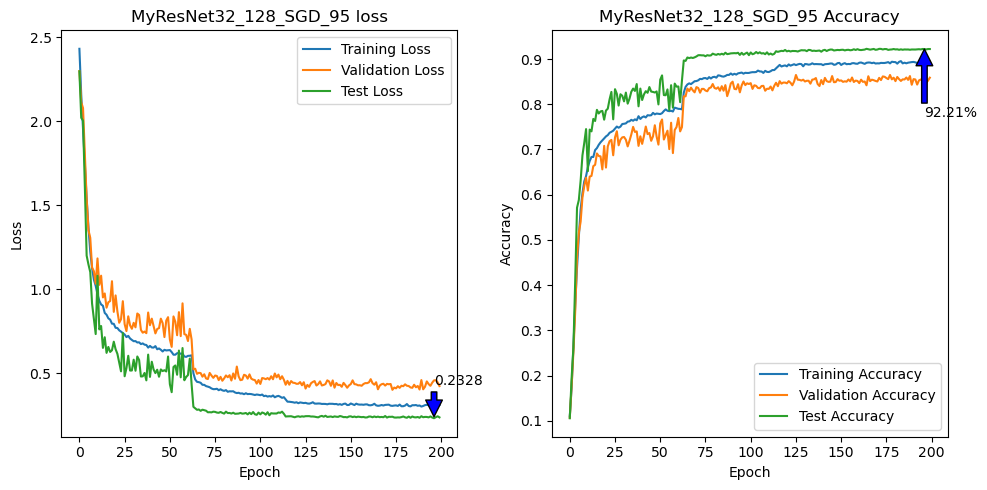

In [19]:
view = LogViewer(logs)
view.draw(title=file_name+"_95", min_marker=True)

In [ ]:
view.print_all()